In [13]:
# imports
import requests
import pandas as pd
import os

# data visualization for outlier detection
import seaborn as sns 
import matplotlib.pyplot as plt

# Foursquare

Send a request to Foursquare with a small radius (1000m) for all the bike stations in your city of choice. 

In [4]:
# Load bike station data from previously exported .csv (See citybikes.ipynb)
station_data = pd.read_csv("../data/citybike_stations.csv")

station_data.head(5)

,station_id,station_name,free_bikes,empty_slots,latitude,longitude
0,af1d0f25cbc75377878349fde4d86133,Merchant Square - ELECTRIC,7,2.0,55.858167,-4.245483
1,71b02b6f26f03e58c97dec1e1c9faa00,Botanic Gardens - ELECTRIC,1,7.0,55.878278,-4.288487
2,fa6bc682e8627d66891c2b6250c81b1e,Mitchell Library,7,0.0,55.864788,-4.271852
3,a087989280fd941fd9c41c3e787940ae,University of Strathclyde (North),1,2.0,55.862983,-4.241000
4,eb47a36e3d5fe5bc456397413bd2aa75,Bridge Street Subway - ELECTRIC,5,3.0,55.852500,-4.258850


In [5]:
# Create a dictionary containing the station id (for later use), and formatted coordinates to be used in the below API call
station_coordinates = []

# For every item & row in the CSV
for index, row in station_data.iterrows():
    # Gather the id, lat & long for each station
    station_id = row['station_id']
    lat = row['latitude']
    lon = row['longitude']
    # Load the values into a dictionary
    station_data = {'station_id': station_id, 'coords': f"{lat},{lon}"}
    # Add it to our coordinate list
    station_coordinates.append(station_data)

# Headers & parameters needed for FourSquare
headers = {"Accept": "application/json"}
headers['Authorization'] = os.environ["FOURSQUARE_API_KEY"]
radius_to_search = 1000 # Distance of POI from bike station location (in meters)

# Send an API request for every pair of station coordinates to compile POI data
poi_data = []
for station in station_coordinates:
    # Create the API call using the bike station location and provided search radius
    request_url = "https://api.foursquare.com/v3/places/search?ll=" + station['coords'] + "&radius=" + str(radius_to_search)
    response = requests.get(request_url, headers=headers)
    poi_data.append({'station_id': station['station_id'], 'api-data': response.json()}) # Return the station ID and JSON response

Load the API data into a DataFrame

In [6]:
# Load the compiled data into a Pandas dataframe 
poi_data_df = pd.DataFrame(poi_data)

poi_data_df.head(5)

,station_id,api-data
0,af1d0f25cbc75377878349fde4d86133,{'results': [{'fsq_id': '54c7cade498e300defb09...
1,71b02b6f26f03e58c97dec1e1c9faa00,{'results': [{'fsq_id': '4b9bc057f964a5201c213...
2,fa6bc682e8627d66891c2b6250c81b1e,{'results': [{'fsq_id': '4b852d7bf964a5207d4f3...
3,a087989280fd941fd9c41c3e787940ae,{'results': [{'fsq_id': '57c45369498e5276e3a65...
4,eb47a36e3d5fe5bc456397413bd2aa75,{'results': [{'fsq_id': '4b1583cef964a520fbad2...


In [7]:
# This cell will extract the API data using a loop, creating a new data frame with the station_id and contents of api-data

results_df_list = [] # Empty list to store our results

# Iterate through every row in the POI dataframe
for index, row in poi_data_df.iterrows():
    # Extract the foursquare results from the data column
    results = row['api-data']['results']
    
    # Check if the data exists (without this, excess blank rows will be created)
    if len(results) > 0:
        # Populate a dataframe with the extracted data
        results_df = pd.DataFrame(results)
        # Extract the station ID from the Citybikes API
        results_df['station_id'] = row['station_id']

        results_df_list.append(results_df)

# Combine the results from this list across the rows (axis 0) back into our dataframe
poi_data_df = pd.concat(results_df_list, axis=0)

poi_data_df.head(10)

,fsq_id,categories,chains,distance,geocodes,link,location,name,related_places,timezone,station_id
0,54c7cade498e300defb0985f,"[{'id': 13034, 'name': 'Café', 'icon': {'prefi...",[],31,"{'main': {'latitude': 55.858485, 'longitude': ...",/v3/places/54c7cade498e300defb0985f,"{'address': '6 Wilson St', 'admin_region': 'Sc...",Wilson Street Pantry,{},Europe/London,af1d0f25cbc75377878349fde4d86133
1,4bc35be22a89ef3b08e7f488,"[{'id': 13199, 'name': 'Indian Restaurant', 'i...",[],34,"{'main': {'latitude': 55.858078, 'longitude': ...",/v3/places/4bc35be22a89ef3b08e7f488,"{'address': '44 Candleriggs', 'admin_region': ...",The Dhabba,{},Europe/London,af1d0f25cbc75377878349fde4d86133
2,4b50d353f964a520df3327e3,"[{'id': 13025, 'name': 'Wine Bar', 'icon': {'p...",[],71,"{'main': {'latitude': 55.858058, 'longitude': ...",/v3/places/4b50d353f964a520df3327e3,"{'address': '64 Albion St', 'admin_region': 'S...",Cafe Gandolfi,{'children': [{'fsq_id': '5af74197c824ae002c2b...,Europe/London,af1d0f25cbc75377878349fde4d86133
3,4b9cecbcf964a520bd8236e3,"[{'id': 13003, 'name': 'Bar', 'icon': {'prefix...",[],43,"{'main': {'latitude': 55.858429, 'longitude': ...",/v3/places/4b9cecbcf964a520bd8236e3,"{'address': '71-73 Albion St', 'admin_region':...",Merchant Square,{'children': [{'fsq_id': '595f841bf79faa623f93...,Europe/London,af1d0f25cbc75377878349fde4d86133
4,4ba0e8c3f964a520508637e3,"[{'id': 10037, 'name': 'Concert Hall', 'icon':...",[],98,"{'main': {'latitude': 55.85886, 'longitude': -...",/v3/places/4ba0e8c3f964a520508637e3,"{'admin_region': 'Scotland', 'country': 'GB', ...",City Halls,{},Europe/London,af1d0f25cbc75377878349fde4d86133
5,578b6d78498e37a834ddf7fd,"[{'id': 10020, 'name': 'Internet Cafe', 'icon'...",[],150,"{'drop_off': {'latitude': 55.859402, 'longitud...",/v3/places/578b6d78498e37a834ddf7fd,"{'address': '72 Ingram St', 'admin_region': 'S...",iCafe,{},Europe/London,af1d0f25cbc75377878349fde4d86133
6,4b96b832f964a52026e034e3,"[{'id': 13236, 'name': 'Italian Restaurant', '...",[],169,"{'main': {'latitude': 55.859459, 'longitude': ...",/v3/places/4b96b832f964a52026e034e3,"{'address': '64 Ingram St', 'admin_region': 'S...",Italian Kitchen,{},Europe/London,af1d0f25cbc75377878349fde4d86133
7,4b2cfd42f964a520e2cb24e3,"[{'id': 13034, 'name': 'Café', 'icon': {'prefi...",[],168,"{'main': {'latitude': 55.859735, 'longitude': ...",/v3/places/4b2cfd42f964a520e2cb24e3,"{'address': '118 Ingram St', 'address_extended...",Tinderbox,{},Europe/London,af1d0f25cbc75377878349fde4d86133
8,53e52950498ee2c0974731b8,"[{'id': 10000, 'name': 'Arts and Entertainment...",[],199,"{'drop_off': {'latitude': 55.859269, 'longitud...",/v3/places/53e52950498ee2c0974731b8,"{'address': '99 Hutcheson St', 'admin_region':...",DogHouse Merchant City,{},Europe/London,af1d0f25cbc75377878349fde4d86133
9,5ae0490c6bd36b0908402781,"[{'id': 13034, 'name': 'Café', 'icon': {'prefi...",[],252,"{'drop_off': {'latitude': 55.860034, 'longitud...",/v3/places/5ae0490c6bd36b0908402781,"{'address': '15 John St', 'admin_region': 'Sco...",Singl-end Merchant City,{},Europe/London,af1d0f25cbc75377878349fde4d86133


In [8]:
# Renaming some columns to make the contents more obvious
poi_data_df.rename(columns={'distance':'distance_from_station'}, inplace=True)
poi_data_df.rename(columns={'name':'poi_name'}, inplace=True)

# Display altered column headers
poi_data_df.head(1)

,fsq_id,categories,chains,distance_from_station,geocodes,link,location,poi_name,related_places,timezone,station_id
0,54c7cade498e300defb0985f,"[{'id': 13034, 'name': 'Café', 'icon': {'prefi...",[],31,"{'main': {'latitude': 55.858485, 'longitude': ...",/v3/places/54c7cade498e300defb0985f,"{'address': '6 Wilson St', 'admin_region': 'Sc...",Wilson Street Pantry,{},Europe/London,af1d0f25cbc75377878349fde4d86133


### Data Audit

In [31]:
# Datatype Info
poi_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1061 entries, 0 to 9
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   fsq_id                 1061 non-null   object
 1   categories             1061 non-null   object
 2   chains                 1061 non-null   object
 3   distance_from_station  1061 non-null   int64 
 4   geocodes               1061 non-null   object
 5   link                   1061 non-null   object
 6   location               1061 non-null   object
 7   poi_name               1061 non-null   object
 8   related_places         1061 non-null   object
 9   timezone               1061 non-null   object
 10  station_id             1061 non-null   object
dtypes: int64(1), object(10)
memory usage: 99.5+ KB


In [15]:
# Describe numerical columns
poi_data_df.describe()

# In this case both the minimum & maximum values fall into expected ranges

,distance_from_station
count,1061.000000
mean,388.884072
std,218.706180
min,1.000000
25%,204.000000
50%,373.000000
75%,551.000000
max,1001.000000


In [70]:
# Check for null values
null_counts = poi_data_df.isnull().sum()
print(null_counts)

fsq_id                   0
categories               0
chains                   0
distance_from_station    0
geocodes                 0
link                     0
location                 0
poi_name                 0
related_places           0
timezone                 0
station_id               0
dtype: int64


<AxesSubplot:xlabel='distance_from_station', ylabel='Count'>

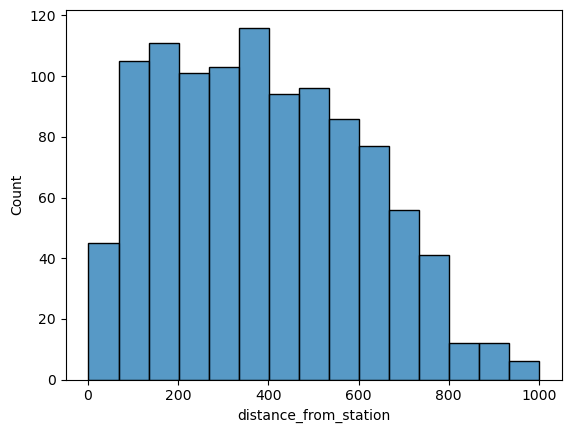

In [19]:
# Pretty even distribution, no outliers detected
sns.histplot(data=poi_data_df,x='distance_from_station')

In [29]:
# Check how many duplicate rows exist in the data
# Have to check the subset as List types cannot be compared
duplicate_count = poi_data_df.duplicated(subset=['fsq_id', 'poi_name']).sum()
print(f"# of duplicate rows: {duplicate_count}")

# of duplicate rows: 515


### Data Cleaning

Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

In [39]:
# Copy the desired columns into a dataframe for cleaning
selected_poi_data_df = poi_data_df[['station_id','distance_from_station','poi_name','categories','location']].copy()

# Display results
selected_poi_data_df.head(5)

,station_id,distance_from_station,poi_name,categories,location
0,af1d0f25cbc75377878349fde4d86133,31,Wilson Street Pantry,"[{'id': 13034, 'name': 'Café', 'icon': {'prefi...","{'address': '6 Wilson St', 'admin_region': 'Sc..."
1,af1d0f25cbc75377878349fde4d86133,34,The Dhabba,"[{'id': 13199, 'name': 'Indian Restaurant', 'i...","{'address': '44 Candleriggs', 'admin_region': ..."
2,af1d0f25cbc75377878349fde4d86133,71,Cafe Gandolfi,"[{'id': 13025, 'name': 'Wine Bar', 'icon': {'p...","{'address': '64 Albion St', 'admin_region': 'S..."
3,af1d0f25cbc75377878349fde4d86133,43,Merchant Square,"[{'id': 13003, 'name': 'Bar', 'icon': {'prefix...","{'address': '71-73 Albion St', 'admin_region':..."
4,af1d0f25cbc75377878349fde4d86133,98,City Halls,"[{'id': 10037, 'name': 'Concert Hall', 'icon':...","{'admin_region': 'Scotland', 'country': 'GB', ..."


In [40]:
# This cell creates and uses two functions to extract the category names & address into seperate columns for legibility

# Function used in conjunction with .apply() to extract category "names" into a easier to read list
def get_category_names(row):
    # Load the dictionary from the categories column
    categories_dic = row['categories']
    
    # Extract the names of each category into a tuple
    # NOTE: Tried list before, but .drop_duplicates() does not work on that data type so I had to settle with tuples
    category_list = []
    for category in categories_dic:
        category_list.append(category['name']) # Append the name to the category tuple
        
    # Return the tuple of category name
    return category_list

# Function used in conjunction with .apply() to extract the address from a location, as we do not require the other data
def get_address(row):
    # Load the dictionary from the location row
    location_dic = row['location']
    
    # Extract the address from the location dictionary
    poi_address = location_dic.get('address', '')
    
    return poi_address

# Use pandas .apply() dataframe function to extract the important values into new columns for much easier analysis
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
selected_poi_data_df['category_names'] = selected_poi_data_df.apply(get_category_names, axis=1)
selected_poi_data_df['address'] = selected_poi_data_df.apply(get_address, axis=1)

# Display the resulting DataFrame
selected_poi_data_df.head(5)

,station_id,distance_from_station,poi_name,categories,location,category_names,address
0,af1d0f25cbc75377878349fde4d86133,31,Wilson Street Pantry,"[{'id': 13034, 'name': 'Café', 'icon': {'prefi...","{'address': '6 Wilson St', 'admin_region': 'Sc...","[Café, Restaurant]",6 Wilson St
1,af1d0f25cbc75377878349fde4d86133,34,The Dhabba,"[{'id': 13199, 'name': 'Indian Restaurant', 'i...","{'address': '44 Candleriggs', 'admin_region': ...",[Indian Restaurant],44 Candleriggs
2,af1d0f25cbc75377878349fde4d86133,71,Cafe Gandolfi,"[{'id': 13025, 'name': 'Wine Bar', 'icon': {'p...","{'address': '64 Albion St', 'admin_region': 'S...","[Wine Bar, Scottish Restaurant, Seafood Restau...",64 Albion St
3,af1d0f25cbc75377878349fde4d86133,43,Merchant Square,"[{'id': 13003, 'name': 'Bar', 'icon': {'prefix...","{'address': '71-73 Albion St', 'admin_region':...","[Bar, Restaurant]",71-73 Albion St
4,af1d0f25cbc75377878349fde4d86133,98,City Halls,"[{'id': 10037, 'name': 'Concert Hall', 'icon':...","{'admin_region': 'Scotland', 'country': 'GB', ...","[Concert Hall, Theater]",


In [41]:
print(f'Shape before de-duplication {selected_poi_data_df.shape}')

Shape before de-duplication (1061, 7)


In [42]:
# Drop columns that we no longer need
selected_poi_data_df = selected_poi_data_df.drop(['categories','location'], axis=1) # - Commented out as I've already run before and keep getting 'doesn't exist' errors

In [43]:
# Remove duplicates (Will happen in cases when two bike stations are within the search radius of eachother)
# NOTE: Stopped working once I added in the station_id as the rows were no longer exact dupes, had to make function below
#selected_poi_data_df = selected_poi_data_df.drop_duplicates()

# Remove rows with duplicate names & addresses, keeping the value with the shortest distance
# ie. Only keep the shortest path per one venue, otherwise analysis will be inaccurate
shortest_distance_rows = {}
# For every row in the dataframe
for index, row in selected_poi_data_df.iterrows():
    # Gather the important data from current row
    poi_name = row['poi_name']
    address = row['address']
    distance_from_station = row['distance_from_station']
    
    # Check if we have already seen this combination before (ie duplicate POI)
    if (poi_name, address) in shortest_distance_rows:
        # Is the distance to station shorter than what we have saved?
        if distance_from_station < shortest_distance_rows[(poi_name, address)]['distance_from_station']:
            # If so, update our dictionary
            shortest_distance_rows[(poi_name, address)] = row
    else:
        # Otherwise, add it to our dictionary (unseen POI)
        shortest_distance_rows[(poi_name, address)] = row

# Load the compiled values into our dataframe
selected_poi_data_df = pd.DataFrame(shortest_distance_rows.values())

# View the final dataframe to be exported to .CSV
selected_poi_data_df.head(5)

,station_id,distance_from_station,poi_name,category_names,address
0,af1d0f25cbc75377878349fde4d86133,31,Wilson Street Pantry,"[Café, Restaurant]",6 Wilson St
1,af1d0f25cbc75377878349fde4d86133,34,The Dhabba,[Indian Restaurant],44 Candleriggs
2,af1d0f25cbc75377878349fde4d86133,71,Cafe Gandolfi,"[Wine Bar, Scottish Restaurant, Seafood Restau...",64 Albion St
3,af1d0f25cbc75377878349fde4d86133,43,Merchant Square,"[Bar, Restaurant]",71-73 Albion St
4,af1d0f25cbc75377878349fde4d86133,98,City Halls,"[Concert Hall, Theater]",


In [38]:
print(f'Shape after de-duplication & column deletion {selected_poi_data_df.shape}')

Shape after de-duplication (518, 5)


In [48]:
# Check how many duplicate rows exist in the data after cleaning
# Have to check the subset as List types cannot be compared
duplicate_count = selected_poi_data_df.duplicated(subset=['station_id', 'poi_name', 'distance_from_station']).sum()
print(f"# of duplicate rows after cleaning: {duplicate_count}")

# of duplicate rows after cleaning: 0


In [39]:
# Export to .csv
selected_poi_data_df.to_csv('../data/Foursquare_POIs.csv', index=False)

# Yelp

Send a request to Yelp with a small radius (1000m) for all the bike stations in your city of choice. 

In [51]:
# Load Citybik.es export (See citybikes.ipynb)
station_data = pd.read_csv("../data/citybike_stations.csv")

station_data.head(5)

,station_id,station_name,free_bikes,empty_slots,latitude,longitude
0,af1d0f25cbc75377878349fde4d86133,Merchant Square - ELECTRIC,7,2.0,55.858167,-4.245483
1,71b02b6f26f03e58c97dec1e1c9faa00,Botanic Gardens - ELECTRIC,1,7.0,55.878278,-4.288487
2,fa6bc682e8627d66891c2b6250c81b1e,Mitchell Library,7,0.0,55.864788,-4.271852
3,a087989280fd941fd9c41c3e787940ae,University of Strathclyde (North),1,2.0,55.862983,-4.241000
4,eb47a36e3d5fe5bc456397413bd2aa75,Bridge Street Subway - ELECTRIC,5,3.0,55.852500,-4.258850


In [52]:
# Headers & parameters needed for Yelp API acording to docs
# https://docs.developer.yelp.com/docs/fusion-intro
yelp_headers = {"accept": "application/json"}
yelp_headers['Authorization'] = "Bearer " + os.environ["YELP_API_KEY_2"] # I have a few API keys
radius_to_search = 1000

In [53]:
# YELP API LOOP
# -- Brought into a seperate cell to restrict the amount of times it needs to be called, reducing API usage
yelp_POIs = []          # List to store POI results
#api_call_limit = 4      # Limit the amount of times the API loop will run (for testing) 
api_limit_counter = 0   # ^

# For each station in the loaded CSV
for index, row in station_data.iterrows():
    #if api_limit_counter >= api_call_limit: # Number of times I want to limit the API to run, used for testing
    #    break
    
    # Gather the id, lat & long for each station
    station_id = row['station_id']
    lat = row['latitude']
    lon = row['longitude']
    
    # Form the API request URL
    yelp_request_url = "https://api.yelp.com/v3/businesses/search?latitude=" + str(lat) + "&longitude=" + str(lon) + "&radius=" + str(radius_to_search)
    
    # Send & recieve the response
    response = requests.get(yelp_request_url, headers=yelp_headers)
    
    # Load the 
    yelp_POIs.append({'station_id': station_id, 'api-data': response.json()['businesses']})
    
    #api_limit_counter += 1
    
print(response)

<Response [200]>


Put your parsed results into a DataFrame

In [54]:
# Load the station ID & API response into a dataframe
# NOTE: Use this cell to reset the DF instead of above to avoid unnessasary API calls
yelp_POIs_df = pd.DataFrame(yelp_POIs)
yelp_POIs_df.head(5)

,station_id,api-data
0,af1d0f25cbc75377878349fde4d86133,"[{'id': 'JNpi062fXUtd3lmGUSu-ww', 'alias': 'ca..."
1,71b02b6f26f03e58c97dec1e1c9faa00,"[{'id': 'R1NcLn3Qi3un6LcaNiPrjQ', 'alias': 'ca..."
2,fa6bc682e8627d66891c2b6250c81b1e,"[{'id': 'cNGlSdCbiAiM3FL9Pl3dGg', 'alias': 'cu..."
3,a087989280fd941fd9c41c3e787940ae,"[{'id': '5TZ23B_ShMLnKgRpRwzgtQ', 'alias': 'dr..."
4,eb47a36e3d5fe5bc456397413bd2aa75,"[{'id': 'UrnzTa6T3sLSVbbXLiYvQA', 'alias': 'pa..."


In [55]:
n = len(pd.unique(yelp_POIs_df['station_id']))
print("No.of.unique stations:", n)

No.of.unique stations: 107


In [56]:
# Now similarly to the Foursquare API we will have to extract the results for each station ID into their own rows

yelp_results_df_list = []

# Iterate through every row in the POI dataframe
for index, row in yelp_POIs_df.iterrows():
    # Extract the foursquare results from the data column
    results = row['api-data']
    
    # Check if the data exists (without this, excess blank rows will be created)
    if len(results) > 0:
        # Populate a dataframe with the extracted data
        results_df = pd.DataFrame(results)
        # Extract the station ID from the Citybikes API
        results_df['station_id'] = row['station_id']

        yelp_results_df_list.append(results_df)

# Combine the results from this list across the rows (axis 0) back into our dataframe
yelp_POIs_df = pd.concat(yelp_results_df_list, axis=0)

In [57]:
yelp_POIs_df.head(5)

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance,station_id
0,JNpi062fXUtd3lmGUSu-ww,café-gandolfi-glasgow-2,Café Gandolfi,https://s3-media3.fl.yelpcdn.com/bphoto/Zh1wQr...,False,https://www.yelp.com/biz/caf%C3%A9-gandolfi-gl...,67,"[{'alias': 'seafood', 'title': 'Seafood'}, {'a...",4.5,"{'latitude': 55.8580469, 'longitude': -4.2442038}",[],££,"{'address1': '64 Albion Street', 'address2': '...",+441415526813,+44 141 552 6813,85.938424,af1d0f25cbc75377878349fde4d86133
1,FwZxNZrEYLdvBioEE76QVA,hutchesons-bar-and-brasserie-glasgow,Hutchesons Bar & Brasserie,https://s3-media4.fl.yelpcdn.com/bphoto/NYO7de...,False,https://www.yelp.com/biz/hutchesons-bar-and-br...,51,"[{'alias': 'scottish', 'title': 'Scottish'}, {...",4.0,"{'latitude': 55.859781774815, 'longitude': -4....",[],££,"{'address1': '158 Ingram Street', 'address2': ...",+441415524050,+44 141 552 4050,225.351596,af1d0f25cbc75377878349fde4d86133
2,ykFuZwPzHrXih4-Y4NAe4Q,brewdog-doghouse-glasgow,BrewDog DogHouse,https://s3-media4.fl.yelpcdn.com/bphoto/0iktlW...,False,https://www.yelp.com/biz/brewdog-doghouse-glas...,48,"[{'alias': 'pubs', 'title': 'Pubs'}, {'alias':...",4.5,"{'latitude': 55.8593557, 'longitude': -4.2480296}",[],££,"{'address1': '99 Hutcheson Street', 'address2'...",+441415526363,+44 141 552 6363,206.258780,af1d0f25cbc75377878349fde4d86133
3,9I0QM3wBHiMzX2AvL3OQeg,the-wilson-street-pantry-glasgow,The Wilson Street Pantry,https://s3-media1.fl.yelpcdn.com/bphoto/G7Vz5a...,False,https://www.yelp.com/biz/the-wilson-street-pan...,88,"[{'alias': 'cafes', 'title': 'Cafes'}, {'alias...",4.5,"{'latitude': 55.8585085104567, 'longitude': -4...",[],£,"{'address1': '6 Wilson Street', 'address2': ''...",+441415520606,+44 141 552 0606,48.999836,af1d0f25cbc75377878349fde4d86133
4,UrnzTa6T3sLSVbbXLiYvQA,paesano-pizza-glasgow,Paesano Pizza,https://s3-media4.fl.yelpcdn.com/bphoto/7KJazO...,False,https://www.yelp.com/biz/paesano-pizza-glasgow...,154,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",4.5,"{'latitude': 55.8596504377382, 'longitude': -4...",[],££,"{'address1': '94 Miller Street', 'address2': '...",+441412585565,+44 141 258 5565,359.689792,af1d0f25cbc75377878349fde4d86133


### Data Audit

In [58]:
# Column information, we can already see of the bat we have more data availble per venue compared to Foursquare
yelp_POIs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2002 entries, 0 to 16
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2002 non-null   object 
 1   alias          2002 non-null   object 
 2   name           2002 non-null   object 
 3   image_url      2002 non-null   object 
 4   is_closed      2002 non-null   bool   
 5   url            2002 non-null   object 
 6   review_count   2002 non-null   int64  
 7   categories     2002 non-null   object 
 8   rating         2002 non-null   float64
 9   coordinates    2002 non-null   object 
 10  transactions   2002 non-null   object 
 11  price          1590 non-null   object 
 12  location       2002 non-null   object 
 13  phone          2002 non-null   object 
 14  display_phone  2002 non-null   object 
 15  distance       2002 non-null   float64
 16  station_id     2002 non-null   object 
dtypes: bool(1), float64(2), int64(1), object(13)
memory us

In [59]:
# Describe numerical columns
yelp_POIs_df.describe()

,review_count,rating,distance
count,2002.000000,2002.000000,2002.000000
mean,37.224276,4.099151,590.439936
std,45.134727,0.705716,353.128631
min,1.000000,1.000000,5.065956
25%,5.250000,4.000000,279.802521
50%,26.000000,4.500000,577.081531
75%,50.000000,4.500000,896.421284
max,286.000000,5.000000,1408.925823


In [69]:
# Check for null values
null_counts = yelp_POIs_df.isnull().sum()
print(null_counts)

id                 0
alias              0
name               0
image_url          0
is_closed          0
url                0
review_count       0
categories         0
rating             0
coordinates        0
transactions       0
price            412
location           0
phone              0
display_phone      0
distance           0
station_id         0
dtype: int64


In [ ]:
# It appears that 412 (before deduplication) venues either do not have a price or are free to experience like parks, I do not want to remove the Parks & other venues so
# instead I will convert the column to a number and replace the nulls with 0 in the "data cleaning" section below

Text(0.5, 1.0, 'Review Count Histogram')

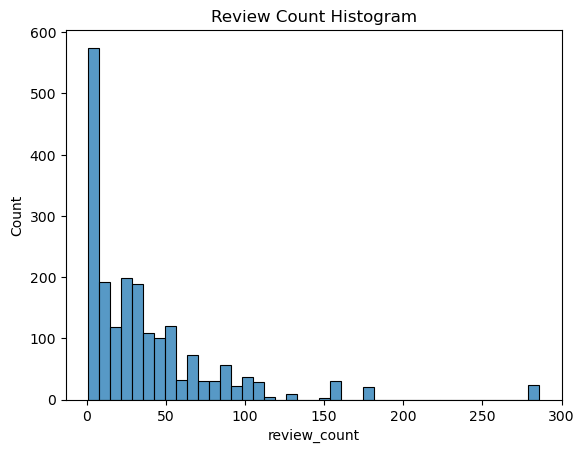

In [62]:
# Check for outliers using various histograms & scatter plots
sns.histplot(data=yelp_POIs_df, x='review_count')
plt.title('Review Count Histogram')

In [73]:
# We can see that there is an outlier with over 250 reviews, lets see which venue this is to determine if it is
# actually an outlier, or a legitimate place that is very popular
yelp_POIs_df[yelp_POIs_df['review_count'] > 250].head(1)

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance,station_id
13,pnSROB18JmOIOi3Nmaih5w,the-butterfly-and-the-pig-glasgow,The Butterfly and the Pig,https://s3-media1.fl.yelpcdn.com/bphoto/JgyArP...,False,https://www.yelp.com/biz/the-butterfly-and-the...,286,"[{'alias': 'scottish', 'title': 'Scottish'}, {...",4.5,"{'latitude': 55.8641959729238, 'longitude': -4...",[],££,"{'address1': '153 Bath Street', 'address2': ''...",+441412217711,+44 141 221 7711,1174.306791,af1d0f25cbc75377878349fde4d86133


In [ ]:
# Even though the above restaurant has an odd amount of reviews, from what I can tell they are all legit, as a result I have left this data point in
# https://www.yelp.ca/biz/the-butterfly-and-the-pig-glasgow#reviews

Text(0.5, 1.0, 'Distance from Stop Histogram')

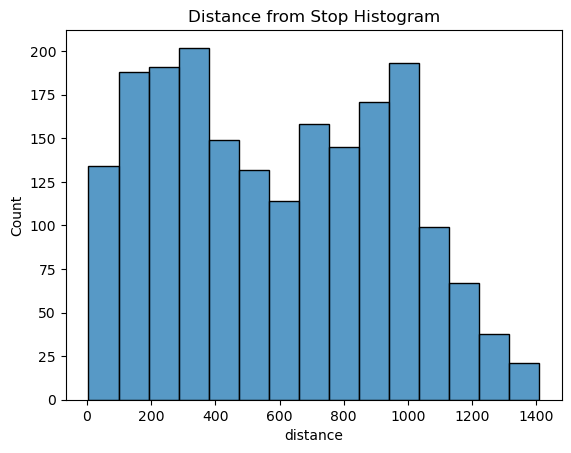

In [74]:
# Pretty even distribution, no obvious outliers
sns.histplot(data=yelp_POIs_df, x='distance')
plt.title('Distance from Stop Histogram')

<AxesSubplot:xlabel='review_count', ylabel='rating'>

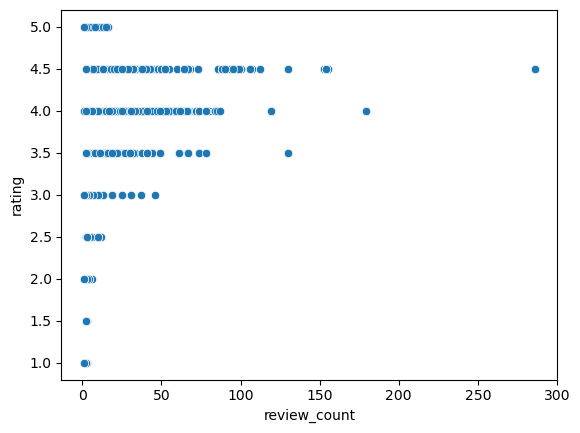

In [67]:
# One interesting note is that low rating resteraunts tend to have a low number of ratings. Overall with more ratings comes a better overall score
sns.scatterplot(data=yelp_POIs_df, x='review_count', y='rating')

C:\Users\Matt\AppData\Local\Temp\ipykernel_24668\368549027.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = yelp_POIs_df.corr()


<AxesSubplot:>

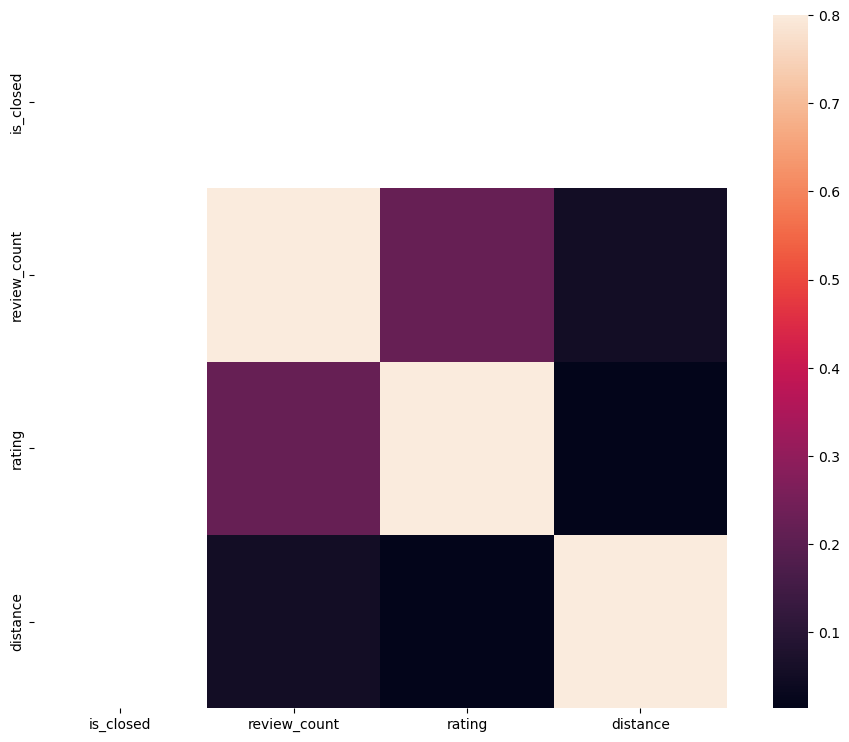

In [68]:
# Correlation Matrix
corrmat = yelp_POIs_df.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True)

### Data Cleaning

In [16]:
# Rename a few columns to make them less ambiguous
yelp_POIs_df.rename(columns={'name':'POI_name','distance':'distance_from_station'}, inplace=True)

yelp_POIs_df.head(1)

,id,alias,POI_name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance_from_station,station_id
0,ykFuZwPzHrXih4-Y4NAe4Q,brewdog-doghouse-glasgow,BrewDog DogHouse,https://s3-media4.fl.yelpcdn.com/bphoto/0iktlW...,False,https://www.yelp.com/biz/brewdog-doghouse-glas...,48,"[{'alias': 'pubs', 'title': 'Pubs'}, {'alias':...",4.5,"{'latitude': 55.8593557, 'longitude': -4.2480296}",[],££,"{'address1': '99 Hutcheson Street', 'address2'...",+441415526363,+44 141 552 6363,206.25878,af1d0f25cbc75377878349fde4d86133


Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

In [17]:
# Copy over relavent columns from the API data into a new DataFrame to be used for cleaning & analysis
selected_yelp_POIs_df = yelp_POIs_df[['station_id','distance_from_station','POI_name','categories','location','rating','review_count','price']].copy()
selected_yelp_POIs_df.head(5)

,station_id,distance_from_station,POI_name,categories,location,rating,review_count,price
0,af1d0f25cbc75377878349fde4d86133,206.258780,BrewDog DogHouse,"[{'alias': 'pubs', 'title': 'Pubs'}, {'alias':...","{'address1': '99 Hutcheson Street', 'address2'...",4.5,48,££
1,af1d0f25cbc75377878349fde4d86133,85.938424,Café Gandolfi,"[{'alias': 'seafood', 'title': 'Seafood'}, {'a...","{'address1': '64 Albion Street', 'address2': '...",4.5,67,££
2,af1d0f25cbc75377878349fde4d86133,225.351596,Hutchesons Bar & Brasserie,"[{'alias': 'scottish', 'title': 'Scottish'}, {...","{'address1': '158 Ingram Street', 'address2': ...",4.0,51,££
3,af1d0f25cbc75377878349fde4d86133,48.999836,The Wilson Street Pantry,"[{'alias': 'cafes', 'title': 'Cafes'}, {'alias...","{'address1': '6 Wilson Street', 'address2': ''...",4.5,88,£
4,af1d0f25cbc75377878349fde4d86133,54.506141,Blackfriars,"[{'alias': 'pubs', 'title': 'Pubs'}]","{'address1': '36 Bell Street', 'address2': '',...",4.0,59,££


In [18]:
# Extract the categories and adresses from the respective columns

# Function used in conjunction with .apply() to extract the address from a location, as we do not require the other data
def get_yelp_address(row):
    # Load the dictionary from the location row
    location_dic = row['location']
    
    # Extract the address from the location dictionary
    poi_address = location_dic.get('address1', '')
    
    return poi_address

# Function used in conjunction with .apply() to extract category "names" into a easier to read list
def get_yelp_category_names(row):
    # Load the dictionary from the categories column
    categories_dic = row['categories']
    
    # Extract the names of each category into a list
    category_names = []
    for category in categories_dic:
        category_names.append(category['title']) # Append the name to the category tuple
        
    # Return the tuple of category name
    return category_names

# Apply the above functions, putting the results into new columns
selected_yelp_POIs_df['address'] = selected_yelp_POIs_df.apply(get_yelp_address, axis=1)
selected_yelp_POIs_df['category_names'] = selected_yelp_POIs_df.apply(get_yelp_category_names, axis=1)

selected_yelp_POIs_df.head(5)

,station_id,distance_from_station,POI_name,categories,location,rating,review_count,price,address,category_names
0,af1d0f25cbc75377878349fde4d86133,206.258780,BrewDog DogHouse,"[{'alias': 'pubs', 'title': 'Pubs'}, {'alias':...","{'address1': '99 Hutcheson Street', 'address2'...",4.5,48,££,99 Hutcheson Street,"[Pubs, Beer, Wine & Spirits, Barbeque]"
1,af1d0f25cbc75377878349fde4d86133,85.938424,Café Gandolfi,"[{'alias': 'seafood', 'title': 'Seafood'}, {'a...","{'address1': '64 Albion Street', 'address2': '...",4.5,67,££,64 Albion Street,"[Seafood, British]"
2,af1d0f25cbc75377878349fde4d86133,225.351596,Hutchesons Bar & Brasserie,"[{'alias': 'scottish', 'title': 'Scottish'}, {...","{'address1': '158 Ingram Street', 'address2': ...",4.0,51,££,158 Ingram Street,"[Scottish, Seafood, Steakhouses]"
3,af1d0f25cbc75377878349fde4d86133,48.999836,The Wilson Street Pantry,"[{'alias': 'cafes', 'title': 'Cafes'}, {'alias...","{'address1': '6 Wilson Street', 'address2': ''...",4.5,88,£,6 Wilson Street,"[Cafes, Coffee & Tea, Breakfast & Brunch]"
4,af1d0f25cbc75377878349fde4d86133,54.506141,Blackfriars,"[{'alias': 'pubs', 'title': 'Pubs'}]","{'address1': '36 Bell Street', 'address2': '',...",4.0,59,££,36 Bell Street,[Pubs]


In [19]:
print(f'Shape before de-duplication {selected_yelp_POIs_df.shape}')

Shape before de-duplication (2002, 10)


In [20]:
# Drop columns that we have already extracted the values from
selected_yelp_POIs_df = selected_yelp_POIs_df.drop(['categories','location'], axis=1)

# Remove rows with duplicate names & addresses, keeping the value with the shortest distance
# ie. Only keep the shortest path per one venue, otherwise analysis will be inaccurate
shortest_distance_rows = {}
# For every row in the dataframe
for index, row in selected_yelp_POIs_df.iterrows():
    # Gather the important data from current row
    poi_name = row['POI_name']
    address = row['address']
    distance_from_station = row['distance_from_station']
    
    # Check if we have already seen this combination before (ie duplicate POI)
    if (poi_name, address) in shortest_distance_rows:
        # Is the distance to station shorter than what we have saved?
        if distance_from_station < shortest_distance_rows[(poi_name, address)]['distance_from_station']:
            # If so, update our dictionary
            shortest_distance_rows[(poi_name, address)] = row
    else:
        # Otherwise, add it to our dictionary (unseen POI)
        shortest_distance_rows[(poi_name, address)] = row

# Load the compiled values into our dataframe
selected_yelp_POIs_df = pd.DataFrame(shortest_distance_rows.values())

# Final view before export to .csv
selected_yelp_POIs_df.head(5)

,station_id,distance_from_station,POI_name,rating,review_count,price,address,category_names
0,af1d0f25cbc75377878349fde4d86133,206.258780,BrewDog DogHouse,4.5,48,££,99 Hutcheson Street,"[Pubs, Beer, Wine & Spirits, Barbeque]"
1,af1d0f25cbc75377878349fde4d86133,85.938424,Café Gandolfi,4.5,67,££,64 Albion Street,"[Seafood, British]"
3,bfdb33b93e6a6a80f01c46a8284203e0,224.454440,Hutchesons Bar & Brasserie,4.0,51,££,158 Ingram Street,"[Scottish, Seafood, Steakhouses]"
3,af1d0f25cbc75377878349fde4d86133,48.999836,The Wilson Street Pantry,4.5,88,£,6 Wilson Street,"[Cafes, Coffee & Tea, Breakfast & Brunch]"
4,af1d0f25cbc75377878349fde4d86133,54.506141,Blackfriars,4.0,59,££,36 Bell Street,[Pubs]


In [21]:
print(f'Shape after de-duplication {selected_yelp_POIs_df.shape}')

Shape after de-duplication (659, 8)


In [ ]:
null_counts = yelp_pois_df.isnull().sum()
print(null_counts)

In [22]:
# Export to .csv
selected_yelp_POIs_df.to_csv('../data/Yelp_POIs.csv', index=False)

# Comparing Results

Which API provided you with more complete data? Provide an explanation. 

In my opinion the Yelp API provided more complete data. Not only did Yelp have an extra ~100 points of interest, but the quality and amount of data was much better (16 columns vs 10).

Get the top 10 restaurants according to their rating

In [23]:
# Top venues by rating (you'll notice half have a small sample size of reviews)
selected_yelp_POIs_df.sort_values('rating', ascending=False).head(10)

,station_id,distance_from_station,POI_name,rating,review_count,price,address,category_names
3,bc208a63ac25b883b9eb6e28bfff2f28,289.056404,The Spice Room,5.0,3,£££,1348 Maryhill Rd,[Indian]
0,2ee7f8a8347b8ee388d6beeef94c837d,214.953151,Abarcrombys Cafe Bar,5.0,2,NaN,180 Dumbarton Road,"[Bars, Cafes]"
6,0cc8c09950e1435ee7782478ed292fef,897.358928,Garlic Delicatessens,5.0,1,NaN,793 Shettleston Road,"[Delis, Delicatessen]"
5,0cc8c09950e1435ee7782478ed292fef,960.919549,The Drum,5.0,1,NaN,1071 Shettleston Road,[Pubs]
4,0cc8c09950e1435ee7782478ed292fef,1016.893577,Enzos Fish & Chips,5.0,1,£,1200 Shettleston Road,"[Fish & Chips, Fast Food]"
0,90ca952e355fd4673ea26061d13d8841,90.071110,Ecco 808 il Cafe,5.0,4,£,808 Crow Road,"[Italian, Butcher]"
0,f6b64fd82fe6e607f1fc788ace31c3a1,136.166963,McDonald's Restaurants,5.0,1,NaN,10 Westhorn Drive,[American (Traditional)]
4,e7b590304d2ae958110e34961830ce68,57.158917,Mcharg Bakers' Shops,5.0,1,£,1493 Paisley Road West,[Bakeries]
7,90ca952e355fd4673ea26061d13d8841,90.071110,Beefcake Cafe,5.0,1,NaN,808 Crow Road,[Cafes]
18,a19e9249f64251a331f70f78845241c9,670.941496,River Kelvin Walkway,5.0,12,NaN,,"[Local Flavor, Landmarks & Historical Building..."


In [24]:

# To get more accurate results, lets limit our search to places with 10 or more reviews
top_glasgow_restaurants = selected_yelp_POIs_df[selected_yelp_POIs_df['review_count'] >= 10]

# Sort by rating
top_glasgow_restaurants = top_glasgow_restaurants.sort_values('rating', ascending=False)

# Select only the columns we need for this analysis
top_glasgow_restaurants = top_glasgow_restaurants[['POI_name', 'category_names', 'rating', 'review_count' ,'price', 'address']]

# Limit to top 10
top_glasgow_restaurants.head(10)

,POI_name,category_names,rating,review_count,price,address
0,Wee Lochan,[Scottish],5.0,15,£££,340 Crow Road
0,Sapori d'Italia,[Italian],5.0,16,££,1021 Cathcart Road
18,River Kelvin Walkway,"[Local Flavor, Landmarks & Historical Building...",5.0,12,NaN,
4,Milk Cafe,"[Cafes, Community Service/Non-Profit]",5.0,10,£,452 Victoria Road
4,Two Fat Ladies,[Seafood],5.0,14,£££,88 Dumbarton Road
2,Black Sheep Bistro,[British],5.0,14,££,10 Clarendon Street
12,Obsession of India,[Indian],5.0,13,NaN,25 High Street
17,Yelp Event: Food Photography & Styling Masterc...,[Yelp Events],5.0,13,NaN,Ocho
1,Shish Mahal,"[Indian, Pakistani]",4.5,28,££,66-68 Park Road
1,Café Gandolfi,"[Seafood, British]",4.5,67,££,64 Albion Street


In [25]:
# We can see that some non restaurant locations were included, Yelp does not have a "restaurant" category
# so we can use the following list and function to remove those rows

values_to_remove = ["Yelp Events","Parks"]

# The following function looks through each category list and will return true or false if the category to remove is found inside
def check_value(category_list):
    not_found = True
    
    # for every value we'd like to remove
    for value in values_to_remove:
        # if it's found in our category list
        if value in category_list:
            # return that it's been found (ie not not_found lol)
            not_found = False
            break
    
    return not_found

# Apply the filter
top_glasgow_restaurants_filtered = top_glasgow_restaurants[top_glasgow_restaurants['category_names'].apply(check_value)]

top_glasgow_restaurants_filtered.head(10)

,POI_name,category_names,rating,review_count,price,address
0,Wee Lochan,[Scottish],5.0,15,£££,340 Crow Road
0,Sapori d'Italia,[Italian],5.0,16,££,1021 Cathcart Road
4,Milk Cafe,"[Cafes, Community Service/Non-Profit]",5.0,10,£,452 Victoria Road
4,Two Fat Ladies,[Seafood],5.0,14,£££,88 Dumbarton Road
2,Black Sheep Bistro,[British],5.0,14,££,10 Clarendon Street
12,Obsession of India,[Indian],5.0,13,NaN,25 High Street
1,Shish Mahal,"[Indian, Pakistani]",4.5,28,££,66-68 Park Road
1,Café Gandolfi,"[Seafood, British]",4.5,67,££,64 Albion Street
2,Hooked,[Fish & Chips],4.5,17,£,1027 Cathcart Road
11,Ka Ka Lok,[Chinese],4.5,23,££,175 Saint Georges Road
